In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import os
df = pd.read_csv("cardio_train.csv",sep=";")

from kmodes.kmodes import KModes

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# supress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
# General info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [4]:
# Are there any `NA`s or missing values in a dataset?
df.isnull().values.any()

False

In [5]:
#removing Outliers
# Let's remove weights and heights, that fall below 2.5% or above 97.5% of a given range.
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)

In [6]:
#In addition, in some cases diastolic pressure is higher than systolic, which is also  incorrect. How many records are inaccurate in terms of blood pressure?
print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

Diastilic pressure is higher than systolic one in 1082 cases


In [7]:
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)

In [8]:
#after removing outliers
df.describe()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000
mean,49895.698065,19468.719979,1.347311,164.554854,73.426805,125.770526,81.046307,1.350953,1.220229,0.085631,0.051877,0.803648,0.488228
std,28840.467755,2460.510296,0.476120,6.830174,11.614806,13.761847,8.239157,0.670076,0.567607,0.279820,0.221781,0.397241,0.499866
min,0.000000,10798.000000,1.000000,150.000000,52.000000,100.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,24867.500000,17677.250000,1.000000,160.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,49902.500000,19705.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74745.750000,21321.000000,2.000000,169.000000,80.000000,135.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,180.000000,106.000000,163.000000,100.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# transforming the column AGE(measured in days) for Years
df['years'] = (df['age'] / 365).round().astype('int')
df.drop(['age'], axis='columns', inplace=True)
df.drop(['id'], axis='columns', inplace=True)



In [10]:
# age_bin in quinquenium 5 years spam
df['age_bin'] = pd.cut(df['years'], [0,20,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], 
                              labels=['0-20', '20-30', '30-35', '35-40','40-45','45-50','50-55','55-60','60-65','65-70','70-75','75-80','80-85','85-90','90-95','95-100'])

In [11]:
# Adding Body Mass Index
df['bmi'] = df['weight']/((df['height']/100)**2)

In [12]:
# transforming the column bmi in Body Mass Index Classes (1 to 6)
rating = []
for row in df['bmi']:
    if row < 18.5 :    rating.append(1) #UnderWeight
    elif row > 18.5 and row  < 24.9:   rating.append(2)#NormalWeight
    elif row > 24.9 and row < 29.9:  rating.append(3)#OverWeight
    elif row > 29.9 and row < 34.9:  rating.append(4)#ClassObesity_1
    elif row > 34.9 and row < 39.9:  rating.append(5)#ClassObesity_2
    elif row > 39.9 and row < 49.9:  rating.append(6)#ClassObesity_3
    elif row > 49.9:  rating.append('Error')
        
    else:           rating.append('Not_Rated')

In [13]:
# inserting Column
df['BMI_Class'] = rating


In [14]:
# general distribuition
df["BMI_Class"].value_counts(normalize=True)

3    0.391773
2    0.361943
4    0.179209
5    0.055801
6    0.009162
1    0.002112
Name: BMI_Class, dtype: float64

In [15]:
# creating a Column for MAP
df['MAP'] = ((2* df['ap_lo']) + df['ap_hi']) / 3

In [16]:
#Creating Classes for MAP
map_values = []
for row in df['MAP']:
    if row < 69.9:    map_values.append(1) #Low
    elif row > 70 and row  < 79.9:   map_values.append(2)#Normal
    elif row > 79.9 and row < 89.9:  map_values.append(3)#Normal
    elif row > 89.9 and row < 99.9:  map_values.append(4)#Normal
    elif row > 99.9 and row < 109.9:  map_values.append(5)#High
    elif row > 109.9 and row < 119.9:  map_values.append(6)#Normal
    elif row > 119.9:  map_values.append(7)
        
    else:           map_values.append('Not_Rated')

In [17]:
#inserting MAP_Class Column
df['MAP_Class'] = map_values

In [18]:
# Reordering Columns
df= df[["gender","height","weight","bmi","ap_hi","ap_lo","MAP","years","age_bin","BMI_Class","MAP_Class","cholesterol","gluc","smoke","active","cardio"]]
df.head()

,gender,height,weight,bmi,ap_hi,ap_lo,MAP,years,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,2,168,62.0,21.967120,110,80,90.000000,50,45-50,2,4,1,1,0,1,0
1,1,156,85.0,34.927679,140,90,106.666667,55,50-55,5,5,3,1,0,1,1
2,1,165,64.0,23.507805,130,70,90.000000,52,50-55,2,4,3,1,0,0,1
3,2,169,82.0,28.710479,150,100,116.666667,48,45-50,3,6,1,1,0,1,1
4,1,156,56.0,23.011177,100,60,73.333333,48,45-50,2,2,1,1,0,0,0


In [19]:
# only Categorical Data Columns DataFrame
df_cat = df[["gender","age_bin","BMI_Class","MAP_Class","cholesterol","gluc","smoke","active","cardio",]]

In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_cat = df_cat.apply(le.fit_transform)
df_cat.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,1,3,1,2,0,0,0,1,0
1,0,4,4,3,2,0,0,1,1
2,0,4,1,2,2,0,0,0,1
3,1,3,2,4,0,0,0,1,1
4,0,3,1,0,0,0,0,0,0


In [21]:
df_male = df_cat.query("gender == 0")
df_female = df_cat.query("gender == 1")
df_male.head()


,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
1,0,4,4,3,2,0,0,1,1
2,0,4,1,2,2,0,0,0,1
4,0,3,1,0,0,0,0,0,0
5,0,5,2,2,1,1,0,0,0
6,0,6,4,2,2,0,0,1,0


In [22]:
df_female.head()


,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,1,3,1,2,0,0,0,1,0
3,1,3,2,4,0,0,0,1,1
7,1,6,3,3,2,2,0,1,1
11,1,4,1,2,0,0,0,1,0
12,1,2,1,2,0,0,0,0,0


In [23]:
# new df to work
df_male = df_cat.query("gender == 0")
df_female = df_cat.query("gender == 1")

In [24]:
df_male.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
1,0,4,4,3,2,0,0,1,1
2,0,4,1,2,2,0,0,0,1
4,0,3,1,0,0,0,0,0,0
5,0,5,2,2,1,1,0,0,0
6,0,6,4,2,2,0,0,1,0


In [25]:
df_female.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,1,3,1,2,0,0,0,1,0
3,1,3,2,4,0,0,0,1,1
7,1,6,3,3,2,2,0,1,1
11,1,4,1,2,0,0,0,1,0
12,1,2,1,2,0,0,0,0,0


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 199450.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 199450.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 199450.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 199450.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 199450.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 24370, cost: 164541.0
Run 1, iteration: 2/100, moves: 4731, cost: 164541.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 168193.0
Init: initi

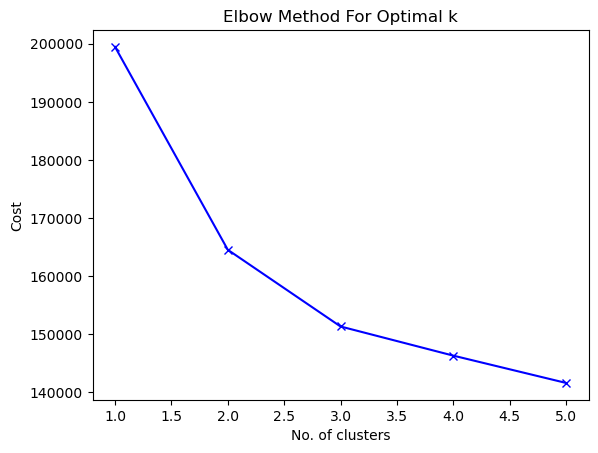

In [26]:
# Elbow curve to find optimal K in Huang init
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=1)
    kmode.fit_predict(df_cat)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 115332.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 115332.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 115332.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 115332.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 115332.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6253, cost: 100964.0
Run 1, iteration: 2/100, moves: 6448, cost: 93623.0
Run 1, iteration: 3/100, moves: 4098, cost: 93623.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iter

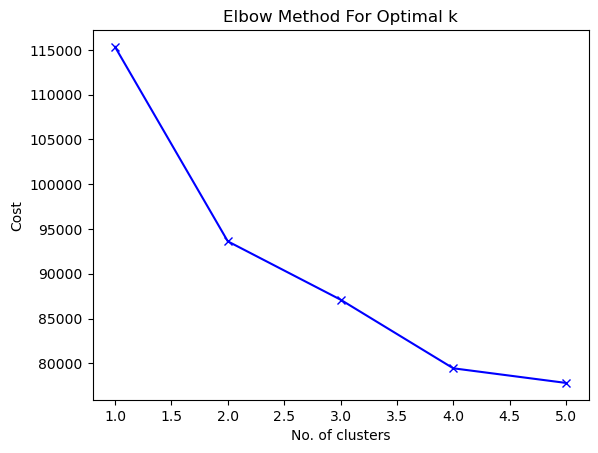

In [27]:
# Elbow curve to find optimal K in Huang
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=1)
    kmode.fit_predict(df_male)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

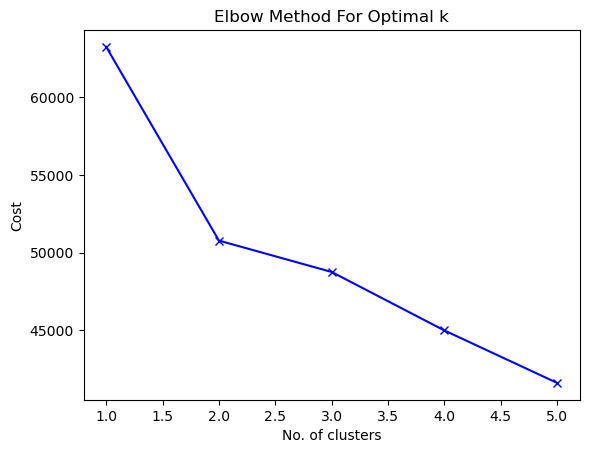

In [28]:
# Elbow curve to find optimal K
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(df_female)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [29]:
# female data
# Building the model with using K-Mode with "Huang" initialization
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 5, verbose=0)
clusters_huang_1 = km_huang.fit_predict(df_female)
clusters_huang_1

array([0, 1, 1, ..., 0, 0, 0], dtype=uint16)

In [30]:
# male data
# Building the model with using K-Mode with "Huang" initialization
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 5, verbose=0)
clusters_huang_2 = km_huang.fit_predict(df_male)
clusters_huang_2

array([0, 0, 1, ..., 0, 0, 0], dtype=uint16)

In [31]:
df_female.insert(0,"Cluster", clusters_huang_1, True)

# female DataFrame with Clusters
df_female.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,0,1,3,1,2,0,0,0,1,0
3,1,1,3,2,4,0,0,0,1,1
7,1,1,6,3,3,2,2,0,1,1
11,0,1,4,1,2,0,0,0,1,0
12,0,1,2,1,2,0,0,0,0,0


In [32]:
df_male.insert(0, "Cluster", clusters_huang_2, True)

# female DataFrame with Clusters
df_male.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
1,0,0,4,4,3,2,0,0,1,1
2,0,0,4,1,2,2,0,0,0,1
4,1,0,3,1,0,0,0,0,0,0
5,0,0,5,2,2,1,1,0,0,0
6,1,0,6,4,2,2,0,0,1,0


In [33]:
# replacing cluster column values to merge dataframes after
df_male["Cluster"].replace({0:2, 1:3}, inplace=True)
df_male.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
1,2,0,4,4,3,2,0,0,1,1
2,2,0,4,1,2,2,0,0,0,1
4,3,0,3,1,0,0,0,0,0,0
5,2,0,5,2,2,1,1,0,0,0
6,3,0,6,4,2,2,0,0,1,0


In [34]:
# merging female and male data
df_clusters = pd.concat([df_female, df_male], ignore_index=True, sort=False)
df_clusters.head(10)

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,0,1,3,1,2,0,0,0,1,0
1,1,1,3,2,4,0,0,0,1,1
2,1,1,6,3,3,2,2,0,1,1
3,0,1,4,1,2,0,0,0,1,0
4,0,1,2,1,2,0,0,0,0,0
5,0,1,5,1,1,0,0,1,1,0
6,0,1,4,3,2,0,0,0,1,0
7,0,1,1,1,2,0,0,0,1,0
8,0,1,5,2,2,0,2,0,0,0
9,1,1,5,2,3,2,0,0,0,1


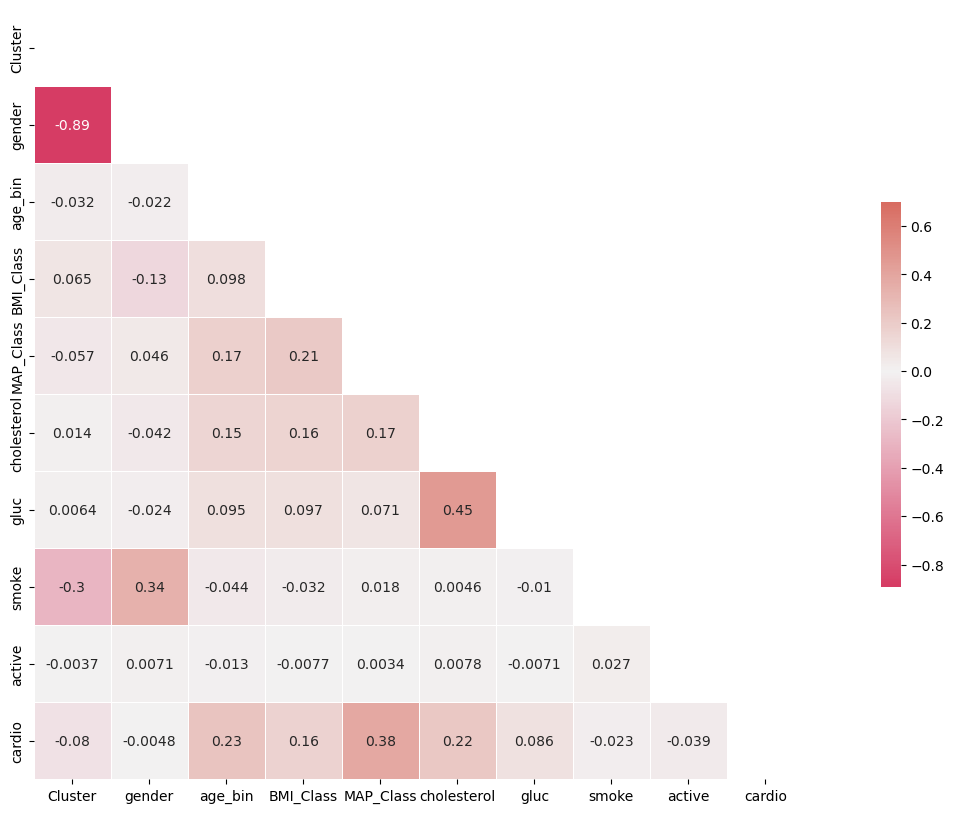

In [35]:
corr = df_clusters.corr()
cmap = sns.diverging_palette(2, 15, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [36]:
# separating clusters
df_female_c0 = df_female[df_female["Cluster"] == 0]
df_female_c1 = df_female[df_female["Cluster"] == 1]


df_female_c0.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
0,0,1,3,1,2,0,0,0,1,0
11,0,1,4,1,2,0,0,0,1,0
12,0,1,2,1,2,0,0,0,0,0
19,0,1,5,1,1,0,0,1,1,0
20,0,1,4,3,2,0,0,0,1,0


In [37]:
# separating clusters
df_male_c2 = df_male[df_male["Cluster"] == 2]
df_male_c3 = df_male[df_male["Cluster"] == 3]


df_male_c2.describe()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
count,25494.0,25494.0,25494.000000,25494.000000,25494.000000,25494.000000,25494.000000,25494.000000,25494.00000,25494.000000
mean,2.0,0.0,4.391072,2.250059,2.404409,0.459363,0.267592,0.016082,0.79556,0.721503
std,0.0,0.0,1.284761,0.907715,0.967372,0.746424,0.620726,0.125794,0.40330,0.448268
min,2.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,2.0,0.0,4.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.00000,0.000000
50%,2.0,0.0,5.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.00000,1.000000
75%,2.0,0.0,5.000000,3.000000,3.000000,1.000000,0.000000,0.000000,1.00000,1.000000
max,2.0,0.0,6.000000,5.000000,5.000000,2.000000,2.000000,1.000000,1.00000,1.000000


In [38]:
#list of columns
my_list = df_clusters.columns.values.tolist()
my_list

['Cluster',
 'gender',
 'age_bin',
 'BMI_Class',
 'MAP_Class',
 'cholesterol',
 'gluc',
 'smoke',
 'active',
 'cardio']

In [39]:
# function to calc % in column
def function(dataframe,valor):
    my_list = dataframe.columns.values.tolist()
    for x in my_list[2:]:
        for y in range(valor):
            percentages = round(((dataframe[x]== y) & (dataframe['cardio']== 1)).sum()/ (dataframe[x]== y).sum()* 100, 2)
            print(percentages)

In [40]:
# applying the function
# there must be a better way to do that though...
function(df_male_c3,8)

0.0
0.0
0.0
16.17
0.0
0.0
0.0
nan
0.0
9.41
0.0
0.0
0.0
0.0
nan
nan
3.48
3.02
4.82
17.34
23.88
23.33
nan
nan
5.49
7.71
12.83
nan
nan
nan
nan
nan
6.09
5.65
6.79
nan
nan
nan
nan
nan
6.11
5.93
nan
nan
nan
nan
nan
nan
6.02
6.12
nan
nan
nan
nan
nan
nan
0.0
100.0
nan
nan
nan
nan
nan
nan


In [41]:
# dictionary with list object in values
# placed by hand...
details = {
    'age_bin_0':[0.0, 0.0, 0.0, 0.0],
    'age_bin_1':[7.62, 92.44, 8.48, 100.0],
    'age_bin_2':[12.94, 92.46, 13.73, 100.0],
    'age_bin_3':[19.73, 92.21, 16.17, 100.0],
    'age_bin_4':[36.29, 100.0, 34.82, 100.0],
    'age_bin_5':[16.6, 84.63, 0.0, 76.59],
    'age_bin_6':[38.56, 93.29, 38.23, 100.0],
    
    'BMI_Class_0':[12.07, 100.0, 9.76, 100.0],
    'BMI_Class_1':[31.1, 100.0, 30.77, 100.0],
    'BMI_Class_2':[8.8, 86.34, 0.0, 78.11],
    'BMI_Class_3':[32.73, 94.86, 22.18, 100.0],
    'BMI_Class_4':[37.62, 94.29, 27.91, 100.0],
    'BMI_Class_5':[66.67, 100.0, 31.54, 100.0],
    
    'MAP_Class_0':[12.55, 85.71, 10.2, 70.29],
    'MAP_Class_1':[11.94, 75.34, 10.1, 75.49],
    'MAP_Class_2':[25.28, 100.0, 17.03, 82.55],
    'MAP_Class_3':[19.89, 85.49, 46.41, 94.35],
    'MAP_Class_4':[60.13, 97.42, 59.48, 97.17],
    'MAP_Class_5':[61.4, 95.04, 58.67, 97.95],
    
    'cholesterol_0':[22.06, 89.16, 18.84, 85.04],
    'cholesterol_1':[29.81, 92.4, 26.92, 90.33],
    'cholesterol_2':[48.41, 92.0, 44.38, 95.2],
    
    'gluc_0' : [23.69, 90.18, 20.78, 86.95],
    'gluc_1' : [28.45, 90.39, 24.72, 90.59],
    'gluc_2' : [31.87, 89.4, 31.12, 91.51],
    
    'smoke_0' : [25.93, 90.48, 21.73, 87.7],
    'smoke_1' : [18.9, 88.86, 19.49, 88.43],
    
    'active_0' : [29.93, 91.7, 24.19, 88.99],
    'active_1' : [23.16, 89.73, 21.1, 87.38],
}



In [42]:
# creating a Dataframe object from dictionary 
# with custom indexing
df_pc = pd.DataFrame(details, index = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3'])
df_pc.head()


,age_bin_0,age_bin_1,age_bin_2,age_bin_3,age_bin_4,age_bin_5,age_bin_6,BMI_Class_0,BMI_Class_1,BMI_Class_2,...,cholesterol_0,cholesterol_1,cholesterol_2,gluc_0,gluc_1,gluc_2,smoke_0,smoke_1,active_0,active_1
Cluster 0,0.0,7.62,12.94,19.73,36.29,16.60,38.56,12.07,31.10,8.80,...,22.06,29.81,48.41,23.69,28.45,31.87,25.93,18.90,29.93,23.16
Cluster 1,0.0,92.44,92.46,92.21,100.00,84.63,93.29,100.00,100.00,86.34,...,89.16,92.40,92.00,90.18,90.39,89.40,90.48,88.86,91.70,89.73
Cluster 2,0.0,8.48,13.73,16.17,34.82,0.00,38.23,9.76,30.77,0.00,...,18.84,26.92,44.38,20.78,24.72,31.12,21.73,19.49,24.19,21.10
Cluster 3,0.0,100.00,100.00,100.00,100.00,76.59,100.00,100.00,100.00,78.11,...,85.04,90.33,95.20,86.95,90.59,91.51,87.70,88.43,88.99,87.38


In [43]:
# creating separate dfs
df_agebins = df_pc.loc[:,"age_bin_0":"age_bin_6"]
df_bmi = df_pc.loc[:,"BMI_Class_0":"BMI_Class_5"]
df_map = df_pc.loc[:,"MAP_Class_0":"MAP_Class_5"]
df_chol = df_pc.loc[:,"cholesterol_0":"cholesterol_2"]
df_gluc = df_pc.loc[:,"gluc_0":"gluc_2"]
df_smokers = df_pc.loc[:,"smoke_0":"smoke_1"]
df_actives = df_pc.loc[:,"active_0":"active_1"]


In [44]:
df_agebins.head()

,age_bin_0,age_bin_1,age_bin_2,age_bin_3,age_bin_4,age_bin_5,age_bin_6
Cluster 0,0.0,7.62,12.94,19.73,36.29,16.60,38.56
Cluster 1,0.0,92.44,92.46,92.21,100.00,84.63,93.29
Cluster 2,0.0,8.48,13.73,16.17,34.82,0.00,38.23
Cluster 3,0.0,100.00,100.00,100.00,100.00,76.59,100.00


## 4.1.2 Body Mass Indexes

In [45]:
df_bmi.head()

,BMI_Class_0,BMI_Class_1,BMI_Class_2,BMI_Class_3,BMI_Class_4,BMI_Class_5
Cluster 0,12.07,31.10,8.80,32.73,37.62,66.67
Cluster 1,100.00,100.00,86.34,94.86,94.29,100.00
Cluster 2,9.76,30.77,0.00,22.18,27.91,31.54
Cluster 3,100.00,100.00,78.11,100.00,100.00,100.00


## 4.1.3 Mean Arterial Pressure

In [46]:
df_map.head()

,MAP_Class_0,MAP_Class_1,MAP_Class_2,MAP_Class_3,MAP_Class_4,MAP_Class_5
Cluster 0,12.55,11.94,25.28,19.89,60.13,61.40
Cluster 1,85.71,75.34,100.00,85.49,97.42,95.04
Cluster 2,10.20,10.10,17.03,46.41,59.48,58.67
Cluster 3,70.29,75.49,82.55,94.35,97.17,97.95


## 4.1.4 Cholesterol

In [47]:
df_chol.head()

,cholesterol_0,cholesterol_1,cholesterol_2
Cluster 0,22.06,29.81,48.41
Cluster 1,89.16,92.40,92.00
Cluster 2,18.84,26.92,44.38
Cluster 3,85.04,90.33,95.20


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#2792a5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    <p style="padding: 10px;
              color:white;"> These results are intuitive
</p></div>

## 4.1.5 Glucose

In [48]:
df_gluc.head()

,gluc_0,gluc_1,gluc_2
Cluster 0,23.69,28.45,31.87
Cluster 1,90.18,90.39,89.40
Cluster 2,20.78,24.72,31.12
Cluster 3,86.95,90.59,91.51


In [49]:
df_smokers.head()

,smoke_0,smoke_1
Cluster 0,25.93,18.90
Cluster 1,90.48,88.86
Cluster 2,21.73,19.49
Cluster 3,87.70,88.43


In [50]:
df_actives.head()

,active_0,active_1
Cluster 0,29.93,23.16
Cluster 1,91.70,89.73
Cluster 2,24.19,21.10
Cluster 3,88.99,87.38


In [51]:
# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB

In [52]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_ml = df_clusters.apply(le.fit_transform)
df_ml.describe()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,gluc,smoke,active,cardio
count,60142.000000,60142.000000,60142.000000,60142.00000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000
mean,1.662765,0.347311,4.042233,1.95213,2.237638,0.350953,0.220229,0.085631,0.803648,0.488228
std,1.057611,0.476120,1.377070,0.92357,0.938629,0.670076,0.567607,0.279820,0.397241,0.499866
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,3.000000,1.00000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2.000000,0.000000,4.000000,2.00000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2.000000,1.000000,5.000000,2.00000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,3.000000,1.000000,6.000000,5.00000,5.000000,2.000000,2.000000,1.000000,1.000000,1.000000


In [53]:
target_name = 'cardio'
data_target = df_clusters[target_name]
data = df_clusters.drop([target_name], axis=1)

In [54]:
train, test, target, target_test = train_test_split(data, data_target, test_size=0.2, random_state=0)

In [55]:
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(train, target, test_size=0.2, random_state=0)

In [56]:
#decision tree classifier
from sklearn.tree import DecisionTreeClassifier

In [57]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train, target)
acc_decision_tree = round(decision_tree.score(train, target) * 100, 2)

In [58]:
acc_test_decision_tree = round(decision_tree.score(test, target_test) * 100, 2)

In [59]:
diff_decision_tree = acc_decision_tree - acc_test_decision_tree

In [60]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [61]:
random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [100, 300]}, cv=5).fit(train, target)
random_forest.fit(train, target)
acc_random_forest = round(random_forest.score(train, target) * 100, 2)

In [62]:
acc_test_random_forest = round(random_forest.score(test, target_test) * 100, 2)

In [63]:
diff_random_forest = acc_random_forest - acc_test_random_forest

In [64]:
#logistic regression
from sklearn.linear_model import LogisticRegression

In [65]:
logreg = LogisticRegression()
logreg.fit(train, target)
acc_log = round(logreg.score(train, target) * 100, 2)

In [66]:
acc_test_log = round(logreg.score(test, target_test) * 100, 2)

In [67]:
diff_log = acc_log - acc_test_log

In [68]:
#MLP
# Import necessary libraries
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Create an MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,50,80), max_iter=1000, random_state=42, verbose=0, validation_fraction=0.2)

# Fit the model on the training data
mlp.fit(train, target)


# Predictions on the validation set
y_pred_mlp = mlp.predict(test)

# Evaluate the MLP model on the validation set
accuracy_mlp = mlp.score(test, target_test)

In [69]:
print("precision for Decision Tree is {0:.2f}%". format(acc_test_decision_tree))
print("precision for Random Forest is {0:.2f}%". format(acc_test_random_forest))
print("precision for Logistic Regression is {0:.2f}%". format(acc_test_log))
print(f"precision for MultiLayer Perceptron is: {accuracy_mlp*100:.2f}%")

precision for Decision Tree is 85.93%
precision for Random Forest is 86.06%
precision for Logistic Regression is 70.69%
precision for MultiLayer Perceptron is: 85.58%
